In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler

from scikeras.wrappers import KerasClassifier

import tensorflow as tf

# Comparison of Classifiers for Student Performance Prediction

The objective in this assignment is to compare the performance of different classifiers on the Student Performance dataset Download Student Performance dataset. What is the best algorithm for the dataset? How does ANNs compare to other ML methods? What is the best ANN architecture? 

In [119]:
student_data = pd.read_csv('data/data.csv',sep=';')
student_data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


# preprocessing of data

In [120]:
label_encoder = LabelEncoder()

student_data['Target'] = label_encoder.fit_transform(student_data['Target'])

student_data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,0
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,2
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,0
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,2
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,2


# Describe the dataset:
This dataset is sourced from a higher education institution and contains information about students enrolled in various undergraduate degree programs. It includes features that provide personal details about the students, such as their marital status, parents education levels, and gender.

Additionally, the dataset includes academic-related information, including the students fields of study, academic performance, and attendance records. Which is the features.

the features are a combination of categorical features encoded to integer, and Continuous features 

The target variable indicates the state of each student at the end of their course, classifying them as a dropout, still enrolled, or graduated.

The purpose of this dataset is to identify potential patterns between the features and the target variable, aiming to understand the factors that influence whether students drop out, continue their studies, or graduate based on their academic paths and personal and family backgrounds.

From the UCI link where this data is from it looks like they already have performed some preprocessing of the data: removed unexplainable outliers, missing values and anomolies. so we don't have to think about this. The categorical values in the features are already encoded. They are encoded from 1 to however many categories there are. 

https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

# Perform exploratory analysis of the dataset
analysing the data can help us determine what kind of changed we should do to the dataset

# data distribution
features: the feature distribution is mixed, there are some normally distributed feautres and some binary. the models that we can test are mlp and sequential. one thing to think about is that if these neural network models are going to work with normally distributed data it is important to scale the data, so it is more easy for them to find the complex patterns in the data.

target: There is some imbalance here, but there is still enough representation of all categories, so i don't think this will be a problem. this is a multiclass problem with three distrinct classes, which we need to think about when making the output layer in the keras models

array([[<Axes: title={'center': 'Marital status'}>,
        <Axes: title={'center': 'Application mode'}>,
        <Axes: title={'center': 'Application order'}>,
        <Axes: title={'center': 'Course'}>,
        <Axes: title={'center': 'Daytime/evening attendance\t'}>,
        <Axes: title={'center': 'Previous qualification'}>],
       [<Axes: title={'center': 'Previous qualification (grade)'}>,
        <Axes: title={'center': 'Nacionality'}>,
        <Axes: title={'center': "Mother's qualification"}>,
        <Axes: title={'center': "Father's qualification"}>,
        <Axes: title={'center': "Mother's occupation"}>,
        <Axes: title={'center': "Father's occupation"}>],
       [<Axes: title={'center': 'Admission grade'}>,
        <Axes: title={'center': 'Displaced'}>,
        <Axes: title={'center': 'Educational special needs'}>,
        <Axes: title={'center': 'Debtor'}>,
        <Axes: title={'center': 'Tuition fees up to date'}>,
        <Axes: title={'center': 'Gender'}>],
   

c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


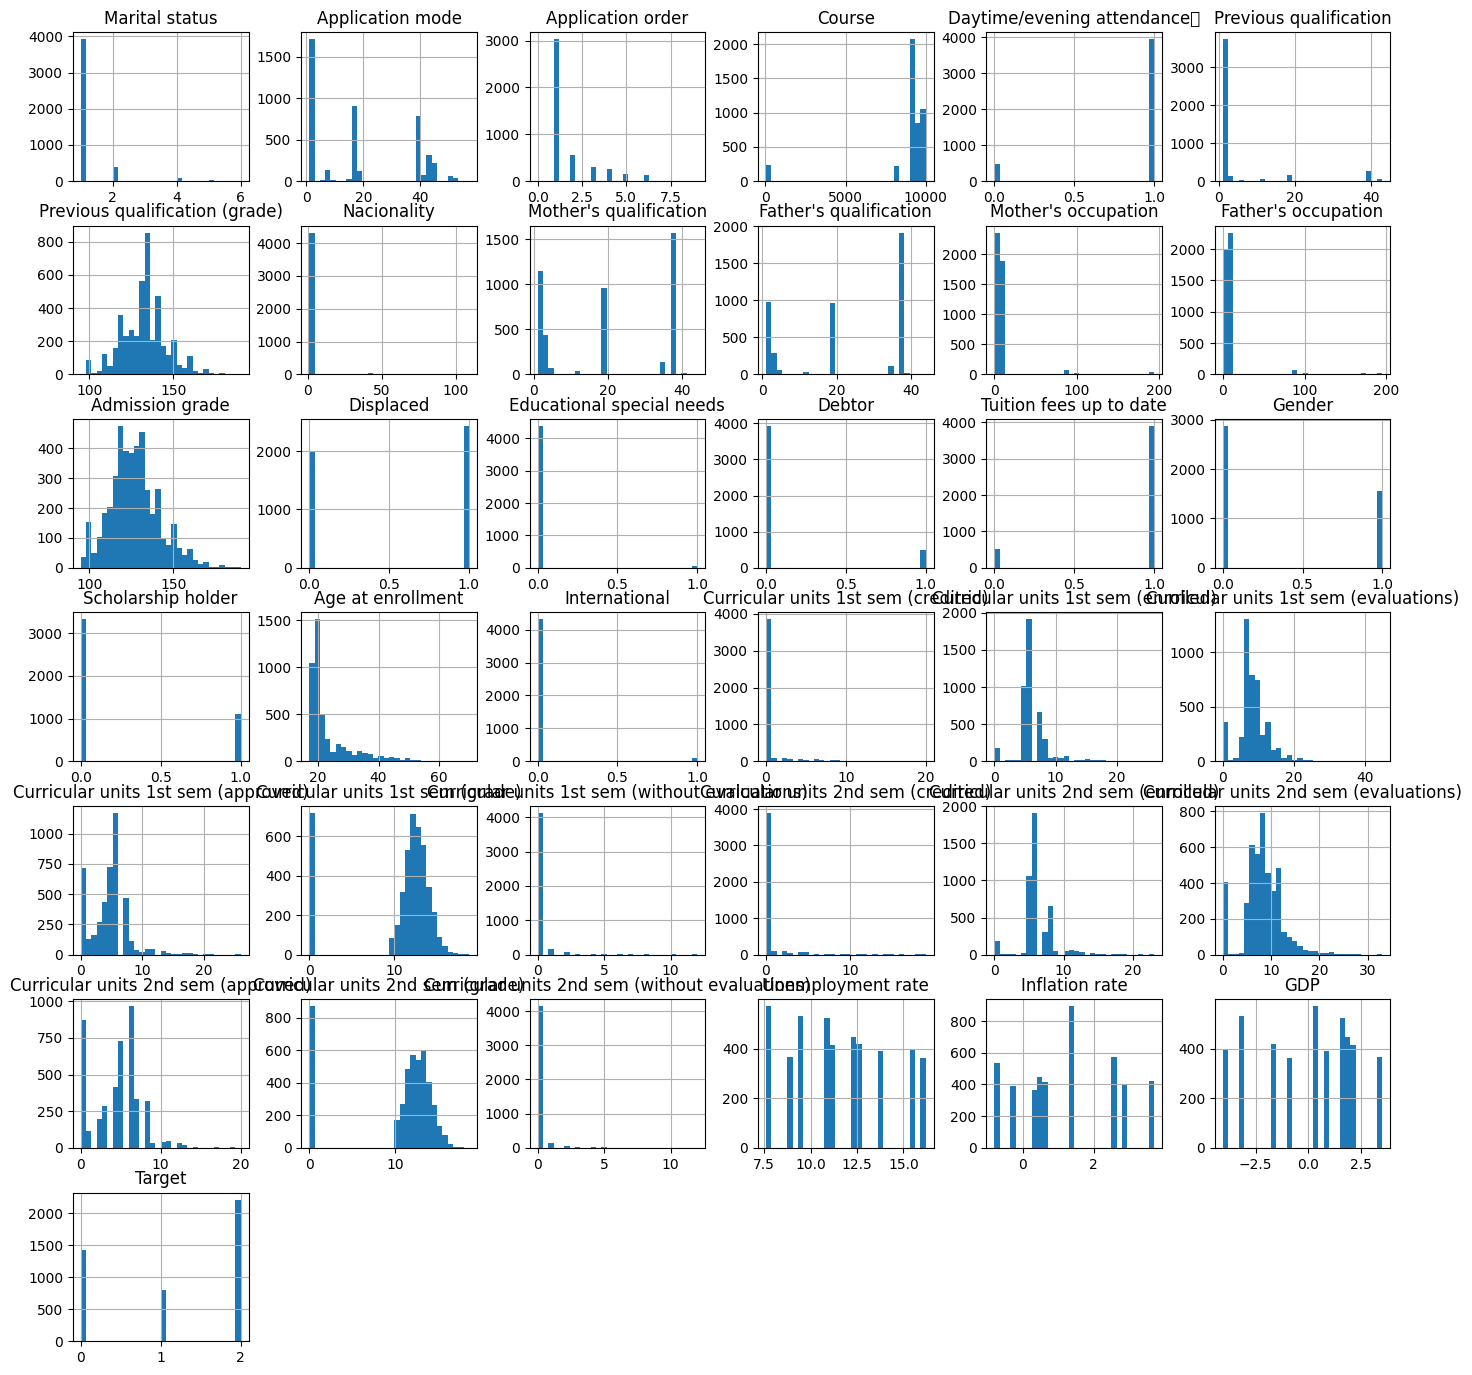

In [121]:
student_data.hist(bins=30, figsize=(17, 17))

# correlation analysis
looking at the correlation between the variables we can see that some of them have very high correlation.  
the correlations we need to consider:  
international and nationality,  
mother and fathers occupation,
and all of the columns for Curricular units 1st sem and Curricular units 2nd sem have some sort of correlation to each other. we need to figure out a smart way to combine these columns

In [122]:
student_corr = student_data.corr()
student_corr.style.background_gradient(cmap='coolwarm')

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
Marital status,1.000000,0.264006,-0.125854,0.046365,-0.274939,0.062529,-0.022406,-0.008843,0.193163,0.130353,0.034994,0.031609,-0.004771,-0.234886,-0.028343,0.034304,-0.087158,-0.014738,-0.053765,0.522717,-0.027905,0.061209,0.052107,0.058030,-0.031027,-0.059811,0.034711,0.062831,0.039026,0.022784,-0.043739,-0.071506,0.020426,-0.020338,0.008761,-0.027003,-0.089804
Application mode,0.264006,1.000000,-0.286357,0.065385,-0.304092,0.422411,-0.039020,-0.000661,0.118974,0.083276,0.051600,0.036707,-0.013271,-0.301197,-0.030779,0.122818,-0.136262,0.160130,-0.163117,0.516243,0.003438,0.247426,0.164299,0.225938,-0.029055,-0.117741,0.045828,0.238445,0.130046,0.167872,-0.071526,-0.115424,0.047983,0.089080,-0.016375,-0.022743,-0.221747
Application order,-0.125854,-0.286357,1.000000,0.059507,0.158657,-0.184315,-0.064484,-0.022416,-0.064956,-0.050288,-0.039039,-0.030014,-0.096930,0.332362,0.025597,-0.072151,0.055891,-0.089559,0.073709,-0.271154,-0.028801,-0.133354,-0.016808,-0.092156,0.035580,0.058308,-0.031699,-0.125815,0.028878,-0.055089,0.071793,0.055517,-0.015757,-0.098419,-0.011133,0.030201,0.089791
Course,0.046365,0.065385,0.059507,1.000000,-0.043151,0.006654,-0.081013,-0.033923,0.054543,0.050724,0.031265,0.028881,-0.125058,-0.087399,-0.018795,-0.032673,0.018381,-0.099571,0.017138,0.042994,-0.026737,-0.096335,0.328461,0.272845,0.180500,0.389349,0.034514,-0.089817,0.401539,0.278797,0.198032,0.348728,0.030816,0.007153,0.017710,-0.020265,0.034219
Daytime/evening attendance,-0.274939,-0.304092,0.158657,-0.043151,1.000000,-0.071871,0.052597,0.018530,-0.204767,-0.139894,-0.019067,-0.015477,0.007970,0.251767,0.031017,0.006658,0.038799,-0.012326,0.093912,-0.462280,0.027973,-0.127466,-0.043056,-0.045889,0.016935,0.063974,0.045630,-0.111953,0.000371,0.014610,0.034022,0.050493,-0.004229,0.061974,-0.024043,0.022929,0.075107
Previous qualification,0.062529,0.422411,-0.184315,0.006654,-0.071871,1.000000,0.104072,-0.029214,-0.013190,-0.006614,0.014822,0.016263,0.184183,-0.115188,-0.010461,0.095104,-0.068453,0.078684,-0.070513,0.156234,-0.026226,0.166025,0.078702,0.130597,0.022020,-0.000497,0.002887,0.143031,0.056179,0.114850,-0.008632,0.000942,0.005102,0.111958,-0.063736,0.064069,-0.056039
Previous qualification (grade),-0.022406,-0.039020,-0.064484,-0.081013,0.052597,0.104072,1.000000,0.054088,-0.060670,-0.035234,-0.011415,-0.019284,0.580444,-0.011001,-0.001458,-0.037507,0.060578,-0.047874,0.055965,-0.111377,0.048529,-0.008872,-0.029169,-0.070702,0.048410,0.059438,-0.003926,-0.018489,-0.031649,-0.061355,0.050263,0.053239,-0.019015,0.045222,0.018710,-0.052620,0.103764
Nacionality,-0.008843,-0.000661,-0.022416,-0.033923,0.018530,-0.029214,0.054088,1.000000,-0.049946,-0.085282,0.043187,0.020626,0.028176,-0.007448,-0.005982,0.051989,-0.026115,-0.023258,-0.010490,-0.003647,0.790935,-0.000370,-0.013292,-0.007763,-0.002268,0.000869,0.009145,-0.007278,-0.020113,-0.025721,-0.017880,-0.008497,-0.014041,-0.000651,-0.008922,0.034478,-0.014801
Mother's qualification,0.193163,0.118974,-0.064956,0.054543,-0.204767,-0.013190,-0.060670,-0.049946,1.000000,0.535140,0.076772,0.052329,-0.054412,-0.081176,-0.0215

# Perform pre-processing of data 

# Standarlize the data
this is especially important working with neural networks

In [123]:
scaler = StandardScaler()

# PCA (dimention reduction)
usually works best with scaler, that is why i am testing it in combination of standardscaler

In [124]:
student_data.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd

In [ ]:
pca = ColumnTransformer([
     
     ("pca1", PCA(1), [7, 20]),        # international and nationality
     ("pca2", PCA(1), [10, 11]),       # mother and fathers occupation
     ("pca3", PCA(1), [21, 27]),       # Curricular units 1st sem matching with their corresponding Curricular units 2nd sem
     ("pca4", PCA(1), [22, 28]),
     ("pca5", PCA(1), [23, 29]),
     ("pca6", PCA(1), [24, 30]),
     ("pca7", PCA(1), [25, 31]),
     ("pca8", PCA(1), [26, 32])
     ], remainder='passthrough')      #the rest of the columns get added back, so we dont loose on important information

# pipe with all the changes to the dataset

In [126]:
def pipe_scaled(model):
    return Pipeline([('scaler', scaler), ('classifier', model)])

In [127]:
def pipe_scaled_pca(model):
    return Pipeline([('scaler', scaler), ('pca', pca), ('classifier', model)])

# Split the dataset into suitable partitions

In [128]:
features = student_data.drop('Target', axis=1)
targets = student_data['Target']

train_val_features, test_features, train_val_targets, test_targets = train_test_split(features, targets, test_size=0.2)

In [129]:
train_val_features.shape

(3539, 36)

# finding out which alterations of the dataset gives the best results
i will test every model with every alteration. When i find the best dataset i will use that to find the best parameters of the models. This will cut down on runtime so i can first focus on the dataset then the parameters. i will just test on simple models, with default parameters for now.

# function to evaluate model

In [130]:
def evaluate(estimator, X, y, model_type): 
    if model_type == 'sklearn':
        probabilities = estimator.predict_proba(X)
    elif model_type == 'keras':
        probabilities = estimator.predict(X)
    
    prediction_indices = np.argmax(probabilities, axis=1)
    
    return {
        'accuracy': accuracy_score(y, prediction_indices),
        'precision': precision_score(y, prediction_indices, average='weighted'),
        'recall': recall_score(y, prediction_indices, average='weighted'),
        'f1': f1_score(y, prediction_indices, average='weighted'),
        'roc_auc': roc_auc_score(y, probabilities, multi_class="ovr") 
    }

# original dataset

In [131]:
mlp_classifier = MLPClassifier(max_iter=1000).fit(train_val_features, train_val_targets)


In [132]:
evaluate(mlp_classifier, test_features, test_targets, 'sklearn')

{'accuracy': 0.31751412429378534,
 'precision': 0.6229689771603122,
 'recall': 0.31751412429378534,
 'f1': 0.17821699036628716,
 'roc_auc': 0.6936999544640412}

In [133]:
sequential_model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(36,)), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

sequential_model1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

sequential_model1.fit(train_val_features, train_val_targets, epochs=20, batch_size=4)

Epoch 1/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - accuracy: 0.4332 - loss: 65.2210
Epoch 2/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - accuracy: 0.5104 - loss: 18.1932
Epoch 3/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step - accuracy: 0.5549 - loss: 12.0322
Epoch 4/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/step - accuracy: 0.5572 - loss: 16.2179
Epoch 5/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step - accuracy: 0.5427 - loss: 18.3012
Epoch 6/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 642us/step - accuracy: 0.5986 - loss: 13.1167
Epoch 7/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step - accuracy: 0.5921 - loss: 13.8297
Epoch 8/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - accuracy: 0.6107 - loss: 12.3709
Epoch 9/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/step - accuracy: 0.5775 - loss: 15.8948
Epoch 10/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step - accuracy: 0.5934 - loss: 13.7806
Epoch 11/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 643us/step - accuracy: 0.6297 - loss: 11.1166
Epoch 12/20
885/885

In [134]:
evaluate(sequential_model1, test_features, test_targets, 'keras')

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


{'accuracy': 0.6768361581920904,
 'precision': 0.7744949155556055,
 'recall': 0.6768361581920904,
 'f1': 0.6867507388593969,
 'roc_auc': 0.8500494826553718}

In [135]:
sequential_model2 = Sequential([
    tf.keras.layers.Input(shape=(36,)), 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax') 
])
sequential_model2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

sequential_model2.fit(train_val_features, train_val_targets, epochs=20, batch_size=4)

Epoch 1/20


c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/step - accuracy: 0.4394 - loss: 42.9423
Epoch 2/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 651us/step - accuracy: 0.5149 - loss: 16.5451
Epoch 3/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - accuracy: 0.5636 - loss: 12.6289
Epoch 4/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/step - accuracy: 0.5459 - loss: 15.5277
Epoch 5/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.5362 - loss: 16.4804
Epoch 6/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - accuracy: 0.5568 - loss: 14.1390
Epoch 7/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step - accuracy: 0.5652 - loss: 15.8058
Epoch 8/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 632us/step - accuracy: 0.5704 - loss: 11.9953
Epoch 9/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step - accuracy: 0.5505 - loss: 15.5068
Epoch 10/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step - accuracy: 0.6074 - loss: 10.7659
Epoch 11/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 652us/step - accuracy: 0.5755 - loss: 11.7807
Epoch 12/20
885/885 ━━━━━━━━━━

In [136]:
evaluate(sequential_model2, test_features, test_targets, 'keras')

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


{'accuracy': 0.584180790960452,
 'precision': 0.6398782988932746,
 'recall': 0.584180790960452,
 'f1': 0.48593116600253083,
 'roc_auc': 0.7176186745337317}

# scaled dataset

In [152]:
mlp_model = MLPClassifier(max_iter=1000)

mlp_pipe = pipe_scaled(mlp_model)
mlp_pipe.fit(train_val_features, train_val_targets)



Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', MLPClassifier(max_iter=1000))])

In [153]:
evaluate(mlp_pipe, test_features, test_targets, 'sklearn')

{'accuracy': 0.7096045197740113,
 'precision': 0.7092576682533563,
 'recall': 0.7096045197740113,
 'f1': 0.7093931941257066,
 'roc_auc': 0.8264254554725333}

In [139]:
def create_model():
    sequential_model1 = Sequential([
    tf.keras.layers.Input(shape=(36,)), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
    sequential_model1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return sequential_model1

model = KerasClassifier(model=create_model, verbose=0, epochs=20, batch_size=4)


sequential_model1_pipe = pipe_scaled(model)


sequential_model1_pipe.fit(train_val_features, train_val_targets)



c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 KerasClassifier(batch_size=4, epochs=20, model=<function create_model at 0x0000028062A4A710>, verbose=0))])

In [140]:
evaluate(sequential_model1_pipe, test_features, test_targets, 'sklearn')

{'accuracy': 0.7423728813559322,
 'precision': 0.7339473203372716,
 'recall': 0.7423728813559322,
 'f1': 0.7353632383527007,
 'roc_auc': 0.8628398557300905}

In [141]:
def create_model():
    sequential_model2 = Sequential([
    tf.keras.layers.Input(shape=(36,)), 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
    sequential_model2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return sequential_model2

model = KerasClassifier(model=create_model, verbose=0, epochs=20, batch_size=4)


sequential_model2_pipe = pipe_scaled(model)


sequential_model2_pipe.fit(train_val_features, train_val_targets)


c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 KerasClassifier(batch_size=4, epochs=20, model=<function create_model at 0x0000028053F431C0>, verbose=0))])

In [142]:
evaluate(sequential_model2_pipe, test_features, test_targets, 'sklearn')

{'accuracy': 0.7593220338983051,
 'precision': 0.7472131692148611,
 'recall': 0.7593220338983051,
 'f1': 0.7490869886126107,
 'roc_auc': 0.8698699031524942}

# scaled dataset with pca

In [154]:
mlp_model = MLPClassifier(max_iter=1000)

mlp_pipe = pipe_scaled_pca(mlp_model)
mlp_pipe.fit(train_val_features, train_val_targets)

c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca1', PCA(n_components=1),
                                                  [7, 20]),
                                                 ('pca2', PCA(n_components=1),
                                                  [10, 11]),
                                                 ('pca3', PCA(n_components=1),
                                                  [21, 27]),
                                                 ('pca4', PCA(n_components=1),
                                                  [22, 28]),
                                                 ('pca5', PCA(n_components=1),
                                                  [23, 29]),
                                                 ('pca6', PCA(n_components=1),
                                                  [24, 30]),
                                                 ('pca7', PCA(n_components=1),
                                                  [25, 31]),
                                                 ('pca8', PCA(n_components=1),
                                                  [26, 32])])),
                ('classifier', MLPClassifier(max_iter=1000))])

In [155]:
evaluate(mlp_pipe, test_features, test_targets, 'sklearn')

{'accuracy': 0.6915254237288135,
 'precision': 0.6974330108680785,
 'recall': 0.6915254237288135,
 'f1': 0.6941376052418616,
 'roc_auc': 0.8145654157240876}

In [145]:
def create_model():
    sequential_model1 = Sequential([
    tf.keras.layers.Input(shape=(28,)), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
    sequential_model1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return sequential_model1

model = KerasClassifier(model=create_model, verbose=0, epochs=20, batch_size=4)


sequential_model1_pipe = pipe_scaled_pca(model)


sequential_model1_pipe.fit(train_val_features, train_val_targets)


c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca1', PCA(n_components=1),
                                                  [7, 20]),
                                                 ('pca2', PCA(n_components=1),
                                                  [10, 11]),
                                                 ('pca3', PCA(n_components=1),
                                                  [21, 27]),
                                                 ('pca4', PCA(n_components=1),
                                                  [22, 28]),
                                                 ('pca5', PCA(n_components=1),
                                                  [23, 29]),
                                                 ('pca6', PCA(n_components=1),
                                                  [24, 30]),
                                                 ('pca7', PCA(n_components=1),
                                                  [25, 31]),
                                                 ('pca8', PCA(n_components=1),
                                                  [26, 32])])),
                ('classifier',
                 KerasClassifier(batch_size=4, epochs=20, model=<function create_model at 0x00000280564CF9A0>, verbose=0))])

In [146]:
evaluate(sequential_model1_pipe, test_features, test_targets, 'sklearn')

{'accuracy': 0.7401129943502824,
 'precision': 0.7349829505802445,
 'recall': 0.7401129943502824,
 'f1': 0.7369276445372407,
 'roc_auc': 0.8675208825429448}

In [147]:
def create_model():
    sequential_model2 = Sequential([
    tf.keras.layers.Input(shape=(28,)), 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
    sequential_model2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return sequential_model2

model = KerasClassifier(build_fn=create_model, verbose=0, epochs=20, batch_size=4)


sequential_model2_pipe = pipe_scaled_pca(model)


sequential_model2_pipe.fit(train_val_features, train_val_targets)


c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca1', PCA(n_components=1),
                                                  [7, 20]),
                                                 ('pca2', PCA(n_components=1),
                                                  [10, 11]),
                                                 ('pca3', PCA(n_components=1),
                                                  [21, 27]),
                                                 ('pca4', PCA(n_components=1),
                                                  [22, 28]),
                                                 ('pca5', PCA(n_components=1),
                                                  [23, 29]),
                                                 ('pca6', PCA(n_components=1),
                                                  [24, 30]),
                                                 ('pca7', PCA(n_components=1),
                                                  [25, 31]),
                                                 ('pca8', PCA(n_components=1),
                                                  [26, 32])])),
                ('classifier',
                 KerasClassifier(batch_size=4, build_fn=<function create_model at 0x000002806209D750>, epochs=20, verbose=0))])

In [148]:
evaluate(sequential_model2_pipe, test_features, test_targets, 'sklearn')

{'accuracy': 0.7581920903954802,
 'precision': 0.7512446839258433,
 'recall': 0.7581920903954802,
 'f1': 0.7501922148928606,
 'roc_auc': 0.8639303986704702}

# the best dataset
this is scaled data with pca, this dataset will be used when finding the best parameters for the models. This dataset gave overall better results by a small bit.


# use hyperparameter tuning to find the best possible network configuration

# grid search funtion
this will be used to tune the parameters of the model. i have removed outer loop for this function, because it took way to long to test this amount of parameters, so i chose to leave it out for now.

In [158]:
def find_best_models(model, dt_params):
    metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc_ovr_weighted']

    inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=13)

    dt_cv_results = []
    dt_estimators = []
    dt_test_scores = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc_auc': [],
    }

    dt_grid = GridSearchCV(model, dt_params, cv=inner_cv, scoring=metrics, refit='f1_weighted',return_train_score=True)
    dt_grid.fit(train_val_features, train_val_targets)

    cv_results = pd.DataFrame(dt_grid.cv_results_)
    dt_cv_results.append(cv_results)
    dt_estimators.append(dt_grid.best_estimator_)

    evaluation = evaluate(dt_grid, train_val_features, train_val_targets, 'sklearn')
    dt_test_scores['accuracy'].append(evaluation['accuracy'])
    dt_test_scores['precision'].append(evaluation['precision'])
    dt_test_scores['recall'].append(evaluation['recall'])
    dt_test_scores['f1'].append(evaluation['f1'])
    dt_test_scores['roc_auc'].append(evaluation['roc_auc'])
    return dt_estimators, dt_cv_results, dt_test_scores



# MLPClassifier
first i will test the MLP classifier. This is a type of neural network that can be used just like any other classifier, even though it's based on a neural network architecture. this is a feed forward neural network that uses dens layers.

parameters i will tune:  
hidden_layers_sizes: this detemines the amount of layers and neurons there are in each layer, which will determine the modes learning capacity and how complex the model is.  
activation: this detemines the activation function that is used to make the hidden layers    
solver: will minimize the loss function  
max_iter: the maximum number of iterations, it stops at this number if the function does not convergence  


In [159]:
MLP_params = {
        'classifier__hidden_layer_sizes': [1,2,3],
        'classifier__activation': ['logistic', 'tanh', 'relu'],
        'classifier__solver': ['sgd', 'adam'],
        'classifier__max_iter': [100, 150, 200]
        
    }
best_models_mlp_model, cv_results, model_scores = find_best_models(pipe_scaled_pca(MLPClassifier()), MLP_params)

c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Kosov\AppData\Local\Programs\

In [160]:
print(best_models_mlp_model)

[Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca1', PCA(n_components=1),
                                                  [7, 20]),
                                                 ('pca2', PCA(n_components=1),
                                                  [10, 11]),
                                                 ('pca3', PCA(n_components=1),
                                                  [21, 27]),
                                                 ('pca4', PCA(n_components=1),
                                                  [22, 28]),
                                                 ('pca5', PCA(n_components=1),
                                                  [23, 29]),
                                                 ('pca6', PCA(n_components=1),
                                                  [24, 30]),
                              

In [161]:
best_model_mlp = best_models_mlp_model[0]
evaluate(best_model_mlp, test_features, test_targets, 'sklearn')

{'accuracy': 0.7627118644067796,
 'precision': 0.7523435254387558,
 'recall': 0.7627118644067796,
 'f1': 0.7520547329911708,
 'roc_auc': 0.8740337171008079}

# sequential models:
The parameters i am tuning:  
optimizer: this is important to detemine how the model should update it's weigths 
epochs: number of complete pases through the dataset 
batch size: number of training samples processed before updating the models weights  
number of hidden layers: depth of the network, detemines how complex the model gets  
number of neurons in the layers: controls the size of each layer, and how many details the dataset can catch   

# sequential model #1
For the first sequential model i am using a more simpel architecture with only dens layers.
The dens layer is 

to use grid search on a model that is not an sklearn classifier i have to wrap it in with a kerasregressor, so i can use sklearn functions with it, like pipe also. 

In [168]:
def create_model(hidden_layers=1, optimizer='adam', activation='relu', num_neurons=128):
    model = Sequential({tf.keras.layers.Input(shape=(28,))})

    for _ in range(hidden_layers - 1):
        model.add(Dense(num_neurons, activation=activation))

    model.add(Dense(3, activation='softmax')) 
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


param_grid = {
    'classifier__model__optimizer': ['adam', 'sgd', 'rmsprop'],
    'classifier__epochs': [10, 50],
    'classifier__batch_size': [32, 64],
    'classifier__hidden_layers': [1, 2, 3],
    'classifier__num_neurons': [64, 128, 256]
}



model = KerasClassifier(model=create_model, hidden_layers=1, num_neurons=128 ,verbose=0)

pipeline = pipe_scaled_pca(model)
best_models_S_model, cv_results, model_scores = find_best_models(pipeline, param_grid)



In [169]:
print(best_models_S_model)

[Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca1', PCA(n_components=1),
                                                  [7, 20]),
                                                 ('pca2', PCA(n_components=1),
                                                  [10, 11]),
                                                 ('pca3', PCA(n_components=1),
                                                  [21, 27]),
                                                 ('pca4', PCA(n_components=1),
                                                  [22, 28]),
                                                 ('pca5', PCA(n_components=1),
                                                  [23, 29]),
                                                 ('pca6', PCA(n_components=1),
                                                  [24, 30]),
                              

In [170]:
best_model_S1 = best_models_S_model[0]
evaluate(best_model_S1, test_features, test_targets, 'sklearn')

{'accuracy': 0.7661016949152543,
 'precision': 0.7553000665290315,
 'recall': 0.7661016949152543,
 'f1': 0.7571443579318998,
 'roc_auc': 0.8767380142168801}

# sequential model #2
with different structure, added dropout layer. this dropout layer is supposed to make the model less overfitted by making a fraction of the dataset to zero's turning each forward pass of training. this will improve generlization

In [175]:
def create_model(drop_out=0.1, hidden_layers=1, hidden_layers_drop_out=1, optimizer='adam', activation='relu', num_neurons=128):
    model = Sequential({tf.keras.layers.Input(shape=(28,))})

    for _ in range(hidden_layers - 1):
        model.add(Dense(num_neurons, activation=activation))
        if hidden_layers_drop_out > 0:
            model.add(Dropout(drop_out))

    model.add(Dense(3, activation='softmax')) 
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


param_grid = {
    'classifier__model__optimizer': ['adam', 'sgd'],
    'classifier__epochs': [10, 50],
    'classifier__batch_size': [32, 64],
    'classifier__hidden_layers': [1, 3],
    'classifier__num_neurons': [64, 128],
    'classifier__drop_out': [0.1, 0.3],
    'classifier__hidden_layers_drop_out': [1, 3],
}



model = KerasClassifier(model=create_model, drop_out=0.1, hidden_layers=1, hidden_layers_drop_out=1, num_neurons=128 ,verbose=0)

pipeline = pipe_scaled_pca(model)
best_models_S_model, cv_results, model_scores = find_best_models(pipeline, param_grid)



c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
256 fits failed out of a total of 512.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
256 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-pack

In [176]:
print(best_models_S_model)

[Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca1', PCA(n_components=1),
                                                  [7, 20]),
                                                 ('pca2', PCA(n_components=1),
                                                  [10, 11]),
                                                 ('pca3', PCA(n_components=1),
                                                  [21, 27]),
                                                 ('pca4', PCA(n_components=1),
                                                  [22, 28]),
                                                 ('pca5', PCA(n_components=1),
                                                  [23, 29]),
                                                 ('pca6', PCA(n_components=1),
                                                  [24, 30]),
                              

In [177]:
best_model_S2 = best_models_S_model[0]
evaluate(best_model_S2, test_features, test_targets, 'sklearn')

{'accuracy': 0.7593220338983051,
 'precision': 0.7459949009775,
 'recall': 0.7593220338983051,
 'f1': 0.7440899437301991,
 'roc_auc': 0.869108361359238}

# comparing the results of the best models found

In [179]:
print("best MLP model")
print(evaluate(best_model_mlp, test_features, test_targets, 'sklearn'))
print()
print("best sequential model with the first architecture")
print(evaluate(best_model_S1, test_features, test_targets, 'sklearn'))
print()
print("best sequential model with the second arthitecture")
print(evaluate(best_model_S2, test_features, test_targets, 'sklearn'))

best MLP model
{'accuracy': 0.7627118644067796, 'precision': 0.7523435254387558, 'recall': 0.7627118644067796, 'f1': 0.7520547329911708, 'roc_auc': 0.8740337171008079}

best sequential model with the first architecture
{'accuracy': 0.7661016949152543, 'precision': 0.7553000665290315, 'recall': 0.7661016949152543, 'f1': 0.7571443579318998, 'roc_auc': 0.8767380142168801}

best sequential model with the second arthitecture
{'accuracy': 0.7593220338983051, 'precision': 0.7459949009775, 'recall': 0.7593220338983051, 'f1': 0.7440899437301991, 'roc_auc': 0.869108361359238}


# conclusion
the best model is: the sequention model with the first more simpel architecture, when i used the dataset that was scaled and used PCA. it had slightly better results then the other models, but all of them had pretty good results.  

things to consider with these results:
i could have tried with more parameters, but it took very long time, so maybe i didnt find the best models of each model type. The layers could maybe have been build differently, so that it could work even better with this dataset. i will add the graphs to see that i have found the best parameters, and display results better

The meaning of the results:  
Accuracy: 76.61% of the time the model had predicted the right category for the student.  
preicison: 75.53% of the positive precitions were actually positive, meaning how many instances of the class they got assignet actually where in that class.  
recall: 76.61% of the actual positive instances were correctly identified.
ROC-AUC: shows the models ability to distinguish the classes, and it is right 86.81% of the time.
this model is pretty good at categorizing if a student will drop out or not



# Sources
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html  
hyperparameter-tuning-with-keras-and-gridsearchcv-a-comprehensive-guide-46214cc0d999 (use grid search and non sklearn models)  
https://stackoverflow.com/questions/47788799/grid-search-the-number-of-hidden-layers-with-keras (tune number of layers)  